# Step 9: Scaling Up.

In the previous section we experimented on a dataset that only had 5 flowers. \
We were able to build a model that reached a 97% accuracy and a 0.96 F1 score.

Now let's try to see how our model performs on bigger datasets, with the goal of hitting 95% accuracy on a bigger set containing 41 types of flowers.


## Prediction
I predict we will run into the following difficulties:
 * Needing to re-tune model hyper-parameters to work with more classes. We may even need to swap out the base model for a bigger net.
 * Time to train model will go up. Maybe we need a way to checkpoint our work to disk and run multiple times, or maybe even move to a cloud solution.
 
 Let's see how it goes :) 


In [1]:
import pathlib
import os.path

import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp

In [2]:
%load_ext tensorboard

In [3]:
model_url = 'https://tfhub.dev/google/bit/s-r50x1/1'
base_model = hub.KerasLayer(model_url)

In [4]:
batch_size = 32
epochs=25
img_height = 192
img_width = 192

In [5]:
# Let's define a function for reading our data, since we do it more than once.
def read_data(flower_set):
    data_dir =  pathlib.Path(os.path.abspath("images/" + flower_set + '/'))
    return tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="both", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

In [6]:
from sklearn.metrics import f1_score as sk_f1

# Define our own function since we are working with batch datasets.
def f1_score(model, val_ds):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # We iterate over the dataset to get the true label and input at the same time.
    # Otherwise we will unintentionally shuffle the dataset.
    for image_batch, label_batch in val_ds:
        y_true.append(label_batch)
        preds = model.predict(image_batch, verbose=0)
        y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    
    return sk_f1(correct_labels, predicted_labels, average=None)

## 9.1: Datasets

So far we have been testing our dataset on only 5 flowers. Now let's try scaling it up.

Sets:

| name | size | reason
|------|------|------
|Flowers5| 1,857 | **Prototype set** can iterate quickly on it.
|Flowers15 | 5,902 | **Test scaling** this medium sized set will tell us how increasing the scale impacts our model.
|Flowers41 | 15,329 | **Target**. Meets the minimum requirement of 15,000 files.
|FlowersFinal | 112,196   | **Stretch**. Very large set, could be interesting to build a model on this if time allows.

In [23]:
train5_ds, val5_ds = read_data('Flowers5')
print(train5_ds.class_names)

Found 1857 files belonging to 5 classes.
Using 1486 files for training.
Using 371 files for validation.
['Calceolaria', 'Daffodil', 'Freesia', 'Hibiscus', 'Iris']


In [7]:
train15_ds, val15_ds = read_data('Flowers15')
print(train15_ds.class_names)

Found 5902 files belonging to 15 classes.
Using 4722 files for training.
Using 1180 files for validation.
['Abutilon', "Baby'sBreath", 'Calceolaria', 'Celosia', 'Daffodil', 'Epimedium', 'Erica', 'FrangipaniFlower', 'Freesia', 'FrenchMarigold', 'Hibiscus', 'Hyacinth', 'IpomoeaLobata', 'Iris', 'JohnnyJumpUp']


In [8]:
train41_ds, val41_ds = read_data('Flowers41')
print(train41_ds.class_names)

Found 15329 files belonging to 41 classes.
Using 12264 files for training.
Using 3065 files for validation.
['Abutilon', 'Acacia', 'Alyssum', "Baby'sBreath", 'Bellflower', 'BleedingHeart', 'Borage', 'Buttercup', 'Calceolaria', 'Celosia', 'Chrysanthemum', 'Clover', 'Crocus', 'Daffodil', 'Daisy', 'Dandelion', 'Diascia', 'Dill', 'Epimedium', 'Erica', 'FrangipaniFlower', 'Freesia', 'FrenchMarigold', 'Fuchsia', 'Gardenia', 'Gladiolas', 'Hibiscus', 'Honeysuckle', 'Hyacinth', 'IpomoeaLobata', 'Iris', 'JacobsLadder', 'Jasmine', 'JohnnyJumpUp', 'Lily', 'Lotus', 'Magnolia', 'Marigold', 'Orchid', 'Roses', 'TobaccoPlant']


In [12]:
train_ds, val_ds = read_data('FlowersFinal')

Found 112196 files belonging to 288 classes.
Using 89757 files for training.
Using 22439 files for validation.


## 9.2: Scaling up to 15 flowers.

### 9.2.1: Run the top model for 5 flowers.
In the previous section we built a prototype on 5 flowers that achieved an accuracy of 97% with an F1 score of 0.96. Let's start by seeing how well that model works on the 15 set.

In [8]:
model_15 = tf.keras.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(15),
])
model_15.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
history = model_15.fit(train15_ds, validation_data=val15_ds, epochs=epochs, verbose=1)

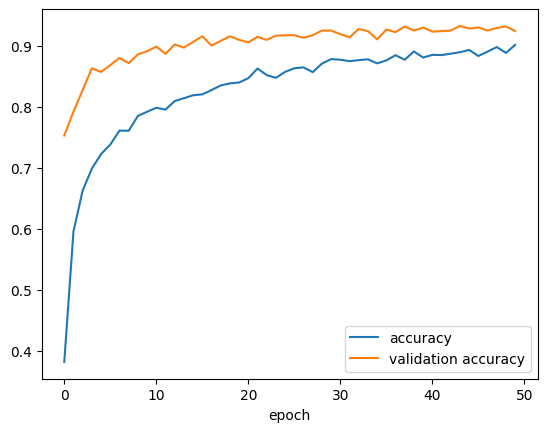

In [11]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.show()

In [12]:
f1 = f1_score(model_15, val15_ds)
print("F1 score:", np.mean(f1))

F1 score: 0.9247144264422004



**Results**: Our model seems to be underfitted, and does not perform as well on this dataset. We likely need to re-tune it. I suspect we need a denser layer.

### 9.2.2: Re-tuning: Wider model.

Let's see if changing the density and dropout will improve our model.

In [8]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32, 48, 64]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))

METRIC_F1_SCORE = 'f1_score'
DIR='logs/hparam_tuning'

with tf.summary.create_file_writer(DIR).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT],
        metrics=[hp.Metric(METRIC_F1_SCORE, display_name='F1 Score')],
    )

In [9]:
def train_test_model(hparams, num_classes, train_ds, val_ds):
    model = tf.keras.Sequential([
        layers.Rescaling(1./255),
        base_model,
        layers.Dense(hparams[HP_NUM_UNITS], activation='relu'),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(num_classes),
    ])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

    model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)

    f1 = f1_score(model, val_ds)
    print("f1:", f1)
    return np.mean(f1)

In [13]:
def run(run_dir, hparams, train_ds, val_ds):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        f1 = train_test_model(hparams, len(train_ds.class_names), train_ds, val_ds)
        tf.summary.scalar(METRIC_F1_SCORE, f1, step=1)

In [21]:
session_num = 0

In [ ]:
for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in np.linspace(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, num=5):
        hparams = {HP_NUM_UNITS: num_units, HP_DROPOUT: dropout_rate}
        run_name = "run-flowers15-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run(DIR + '/' + run_name, hparams, train15_ds, val15_ds)
        session_num += 1

In [ ]:
%tensorboard --logdir logs/hparam_tuning --host localhost

![Tensorboard](step9-15.png)

Re-tuning the layer to have a density of 64 and a dropout of 0.25 gives us an adequate result for this size. This suggests that we may need an even wider network for the 41 flowers.

## 9.3: 41 Flowers

### 9.3.1: Testing the best model for Flowers15 on Flowers41

Now let's take the best model for 15 flowers and see how it does on the 41 flower set. Our goal here is to get close to a 0.95 F1 score.

In [11]:
model_41 = tf.keras.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(41),
])
model_41.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [12]:
history = model_41.fit(train41_ds, validation_data=val41_ds, epochs=2*epochs, verbose=1)

Epoch 1/50
384/384 [==============================] - 64s 156ms/step - loss: 2.4058 - accuracy: 0.3502 - val_loss: 1.4605 - val_accuracy: 0.6029
Epoch 2/50
384/384 [==============================] - 58s 152ms/step - loss: 1.5536 - accuracy: 0.5574 - val_loss: 1.1894 - val_accuracy: 0.6688
Epoch 3/50
384/384 [==============================] - 58s 152ms/step - loss: 1.3069 - accuracy: 0.6202 - val_loss: 1.0246 - val_accuracy: 0.7122
Epoch 4/50
384/384 [==============================] - 58s 152ms/step - loss: 1.1384 - accuracy: 0.6650 - val_loss: 0.9542 - val_accuracy: 0.7367
Epoch 5/50
384/384 [==============================] - 58s 152ms/step - loss: 1.0369 - accuracy: 0.6925 - val_loss: 0.8693 - val_accuracy: 0.7501
Epoch 6/50
384/384 [==============================] - 58s 152ms/step - loss: 0.9394 - accuracy: 0.7161 - val_loss: 0.8440 - val_accuracy: 0.7520
Epoch 7/50
384/384 [==============================] - 58s 152ms/step - loss: 0.8693 - accuracy: 0.7390 - val_loss: 0.8231 - val_ac

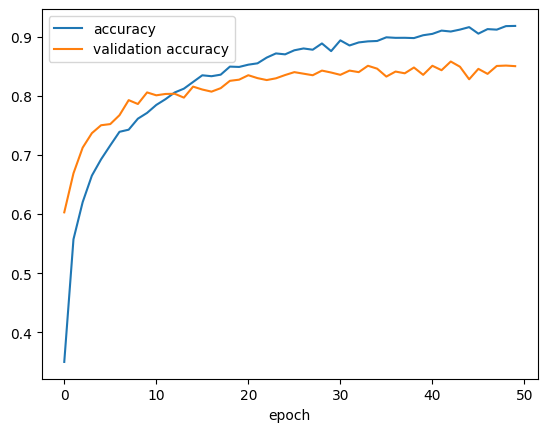

In [13]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.show()

### 9.3.2: Tuning our model

In [10]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([48, 64, 80]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))

METRIC_F1_SCORE = 'f1_score'
DIR='logs/hparam_tuning'

with tf.summary.create_file_writer(DIR).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT],
        metrics=[hp.Metric(METRIC_F1_SCORE, display_name='F1 Score')],
    )

In [11]:
session_num = 0

In [ ]:
for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in np.linspace(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value, num=5):
        hparams = {HP_NUM_UNITS: num_units, HP_DROPOUT: dropout_rate}
        run_name = "run-flowers41-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run(DIR + '/' + run_name, hparams, train41_ds, val41_ds)
        session_num += 1

![Tensorboard](step9-41.png)

A layer of 64 does not seem to be enough... Do we even need a middle layer? The blogs I read did not use one. Let's try without one.

In [ ]:
%tensorboard --logdir logs/hparam_tuning --host localhost

## 9.4: Building a model with the whole dataset (291 Flower classes)

In [8]:
checkpoint_path = "training_final/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [13]:
model_exp = tf.keras.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.Dropout(0.3),
    layers.Dense(len(train_ds.class_names)),
])
model_exp.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
model_exp.load_weights(checkpoint_path)

In [17]:
history = model_exp.fit(train_ds, validation_data=val_ds, epochs=25, verbose=1, callbacks=[cp_callback])

Epoch 1/25
2805/2805 [==============================] - ETA: 0s - loss: 1.4821 - accuracy: 0.6703
Epoch 1: saving model to training_final\cp.ckpt
2805/2805 [==============================] - 451s 161ms/step - loss: 1.4821 - accuracy: 0.6703 - val_loss: 2.0084 - val_accuracy: 0.6525
Epoch 2/25
2805/2805 [==============================] - ETA: 0s - loss: 1.4874 - accuracy: 0.6704
Epoch 2: saving model to training_final\cp.ckpt
2805/2805 [==============================] - 452s 161ms/step - loss: 1.4874 - accuracy: 0.6704 - val_loss: 2.0034 - val_accuracy: 0.6560
Epoch 3/25
2805/2805 [==============================] - ETA: 0s - loss: 1.4763 - accuracy: 0.6731
Epoch 3: saving model to training_final\cp.ckpt
2805/2805 [==============================] - 463s 165ms/step - loss: 1.4763 - accuracy: 0.6731 - val_loss: 2.0220 - val_accuracy: 0.6554
Epoch 4/25
1346/2805 [=============>................] - ETA: 3:11 - loss: 1.4694 - accuracy: 0.6748

KeyboardInterrupt: 

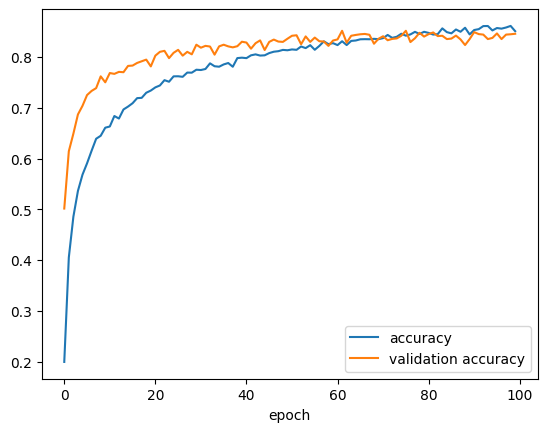

In [24]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('epoch')
plt.show()

## Saving the model so we can use it in our App later.

In [15]:
model_exp.save('saved_model/final')

INFO:tensorflow:Assets written to: saved_model/final\assets


INFO:tensorflow:Assets written to: saved_model/final\assets


In [16]:
import pickle

# Save class names too!
with open('saved_model/flowers_final_labels.pickle', "wb") as f:
    f.write(pickle.dumps(train_ds.class_names))

## Evaluating classes.

I analyzed my confusion matrix and found there were some classes that showed up twice. Both with the scientific name and the common name. Obviously this causes problems for the model...

I went back and update step 2 EDA to deal with this and then updated the dataset to account for it.

**NOTE**: This data output is obsolete.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def _cm_matrix(model, val_ds):

    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # Calculate the confusion matrix.
    # We iterate over the dataset to get the true label and input at the same time.
    # Otherwise we will unintentionally shuffle the dataset.
    for image_batch, label_batch in val_ds:
       y_true.append(label_batch)
       preds = model.predict(image_batch, verbose=0)
       y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    
    cm = confusion_matrix(correct_labels, predicted_labels)
    return cm

In [19]:
cm = _cm_matrix(model_exp, val_ds)

In [20]:
class_names = val_ds.class_names
for r in range(len(class_names)):
    for c in range(len(class_names)):
        if r == c: continue
        if cm[r][c] > 9:
            print("(r, c):", (r,c), "val=", cm[r][c], class_names[r], class_names[c])

(r, c): (23, 20) val= 21 Bergamot BeeBalm
(r, c): (43, 175) val= 20 Calendula Marigold
(r, c): (45, 48) val= 10 CallaLily CannaLily
(r, c): (60, 208) val= 11 Clematis Periwinkle
(r, c): (67, 17) val= 13 Cornflower Bachelor'sButton
(r, c): (83, 159) val= 17 Delphinium Larkspur
(r, c): (99, 127) val= 32 Erica Heather
(r, c): (112, 208) val= 14 FourOclock Periwinkle
(r, c): (116, 175) val= 31 FrenchMarigold Marigold
(r, c): (119, 3) val= 14 Gazania AfricanDaisy
(r, c): (125, 25) val= 33 Guzmania Billbergia
(r, c): (129, 27) val= 15 Helenium BlanketFlower
(r, c): (143, 208) val= 25 Impatiens Periwinkle
(r, c): (150, 264) val= 18 JohnnyJumpUp Viola
(r, c): (180, 2) val= 15 MonksHood Aconite
(r, c): (182, 89) val= 13 Moraea Dietes
(r, c): (183, 208) val= 10 MorningGlory Periwinkle
(r, c): (188, 25) val= 23 Neoregelia Billbergia
(r, c): (205, 120) val= 18 Pelargonium Geranium
(r, c): (214, 154) val= 15 PincushionFlower Knautia
(r, c): (220, 35) val= 12 PowderPuff Bottlebrush
(r, c): (234, 57)

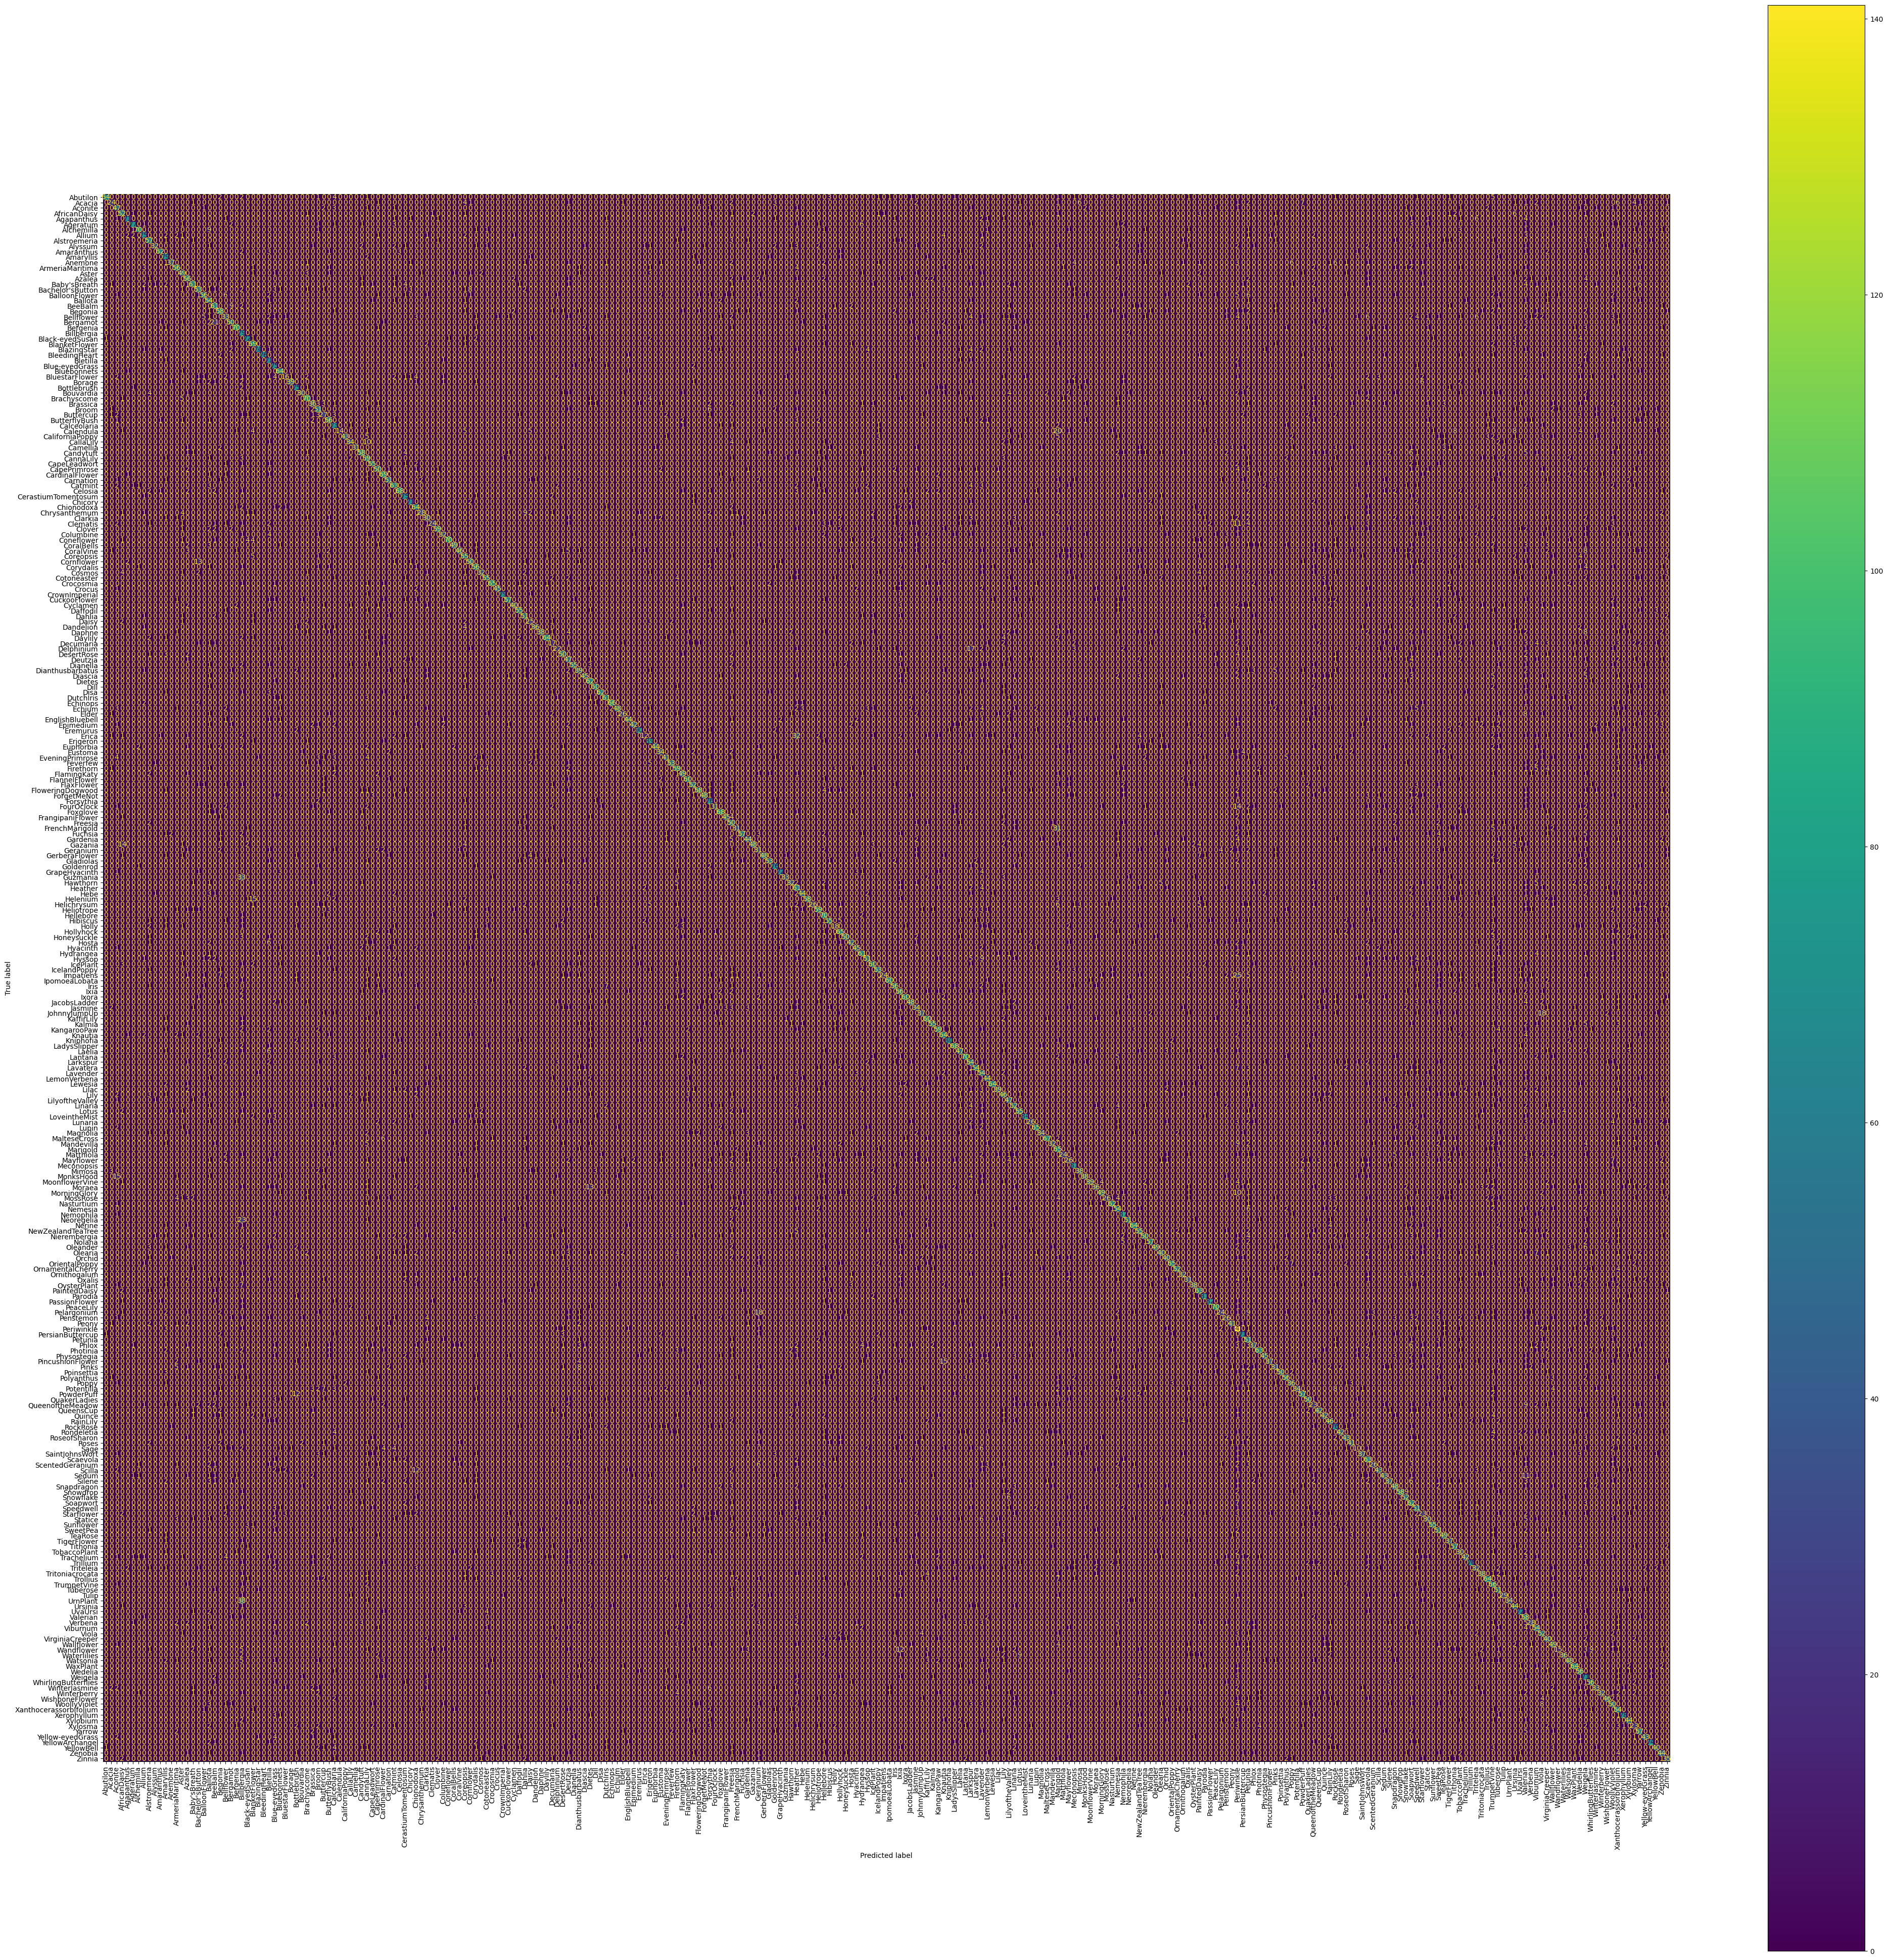

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.class_names)
fig, ax = plt.subplots(figsize=(50,50))
disp.plot(ax=ax, xticks_rotation='vertical')